# Geração de Perguntas

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importando Dataset
import pandas as pd

test = pd.read_json('/content/drive/MyDrive/DatasetPerguntas/test.json')
train = pd.read_json('/content/drive/MyDrive/DatasetPerguntas/train.json')

teste_new = pd.read_json('/content/drive/MyDrive/DatasetPerguntas/NewDataset/train-v2.0.json')

In [ ]:
train = train.iloc[:200,:]

In [ ]:
train.head()

,question,distractor3,distractor1,distractor2,correct_answer,support
0,What type of organism is commonly used in prep...,viruses,protozoa,gymnosperms,mesophilic organisms,"Mesophiles grow best in moderate temperature, ..."
1,What phenomenon makes global winds blow northe...,tropical effect,muon effect,centrifugal effect,coriolis effect,Without Coriolis Effect the global winds would...
2,Changes from a less-ordered state to a more-or...,endothermic,unbalanced,reactive,exothermic,Summary Changes of state are examples of phase...
3,What is the least dangerous radioactive decay?,zeta decay,beta decay,gamma decay,alpha decay,All radioactive decay is dangerous to living t...
4,Kilauea in hawaii is the world’s most continuo...,magma,greenhouse gases,carbon and smog,smoke and ash,Example 3.5 Calculating Projectile Motion: Hot...


## Análise do Dataset

In [ ]:
teste = teste_new['data'][0]
teste

{'title': 'Beyoncé',
 'paragraphs': [{'qas': [{'question': 'When did Beyonce start becoming popular?',
     'id': '56be85543aeaaa14008c9063',
     'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
     'is_impossible': False},
    {'question': 'What areas did Beyonce compete in when she was growing up?',
     'id': '56be85543aeaaa14008c9065',
     'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
     'is_impossible': False},
    {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
     'id': '56be85543aeaaa14008c9066',
     'answers': [{'text': '2003', 'answer_start': 526}],
     'is_impossible': False},
    {'question': 'In what city and state did Beyonce  grow up? ',
     'id': '56bf6b0f3aeaaa14008c9601',
     'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
     'is_impossible': False},
    {'question': 'In which decade did Beyonce become famous?',
     'id': '56bf6b0f3aeaaa14008c9602',
     'answers': [{'text

In [ ]:
teste = teste['paragraphs']

In [ ]:
len(teste)

66

In [ ]:
testeNew = []

In [ ]:
teste[0]['qas'][0]['question']

'When did Beyonce start becoming popular?'

In [ ]:
teste[2]

{'qas': [{'question': 'In her music, what are some recurring elements in them?',
   'id': '56be88473aeaaa14008c9080',
   'answers': [{'text': 'love, relationships, and monogamy',
     'answer_start': 104}],
   'is_impossible': False},
  {'question': 'Time magazine named her one of the most 100 what people of the century?',
   'id': '56be88473aeaaa14008c9083',
   'answers': [{'text': 'influential', 'answer_start': 935}],
   'is_impossible': False},
  {'question': 'Which magazine declared her the most dominant woman musician?',
   'id': '56be88473aeaaa14008c9084',
   'answers': [{'text': 'Forbes', 'answer_start': 985}],
   'is_impossible': False},
  {'question': 'In which decade did the Recording Industry Association of America recognize Beyonce as the The Top Certified Artist?',
   'id': '56bf725c3aeaaa14008c9643',
   'answers': [{'text': '2000s', 'answer_start': 736}],
   'is_impossible': False},
  {'question': 'What magazine rated Beyonce as the most powerful female musician in 2015?'

In [ ]:
for item in teste:
  for i in item['qas']:
    testeNew.append([i['question'],i['answers']])


In [ ]:
testeNew

[['When did Beyonce start becoming popular?',
  [{'text': 'in the late 1990s', 'answer_start': 269}]],
 ['What areas did Beyonce compete in when she was growing up?',
  [{'text': 'singing and dancing', 'answer_start': 207}]],
 ["When did Beyonce leave Destiny's Child and become a solo singer?",
  [{'text': '2003', 'answer_start': 526}]],
 ['In what city and state did Beyonce  grow up? ',
  [{'text': 'Houston, Texas', 'answer_start': 166}]],
 ['In which decade did Beyonce become famous?',
  [{'text': 'late 1990s', 'answer_start': 276}]],
 ['In what R&B group was she the lead singer?',
  [{'text': "Destiny's Child", 'answer_start': 320}]],
 ['What album made her a worldwide known artist?',
  [{'text': 'Dangerously in Love', 'answer_start': 505}]],
 ["Who managed the Destiny's Child group?",
  [{'text': 'Mathew Knowles', 'answer_start': 360}]],
 ['When did Beyoncé rise to fame?',
  [{'text': 'late 1990s', 'answer_start': 276}]],
 ["What role did Beyoncé have in Destiny's Child?",
  [{'tex

In [ ]:
testeNew = pd.DataFrame(testeNew)

In [ ]:
testeNew.head()

,0,1
0,When did Beyonce start becoming popular?,"[{'text': 'in the late 1990s', 'answer_start':..."
1,What areas did Beyonce compete in when she was...,"[{'text': 'singing and dancing', 'answer_start..."
2,When did Beyonce leave Destiny's Child and bec...,"[{'text': '2003', 'answer_start': 526}]"
3,In what city and state did Beyonce grow up?,"[{'text': 'Houston, Texas', 'answer_start': 166}]"
4,In which decade did Beyonce become famous?,"[{'text': 'late 1990s', 'answer_start': 276}]"


In [ ]:
testeNew.rename(columns={0: 'question'}, inplace = True)

In [ ]:
testeNew.rename(columns={1: 'answer'}, inplace = True)

In [ ]:
def replaceAnswer(testeNew):
  for i in testeNew:
    i = i['text']
    return i

In [ ]:
testeNew['answer'] = testeNew['answer'].apply(replaceAnswer)

In [ ]:
context = []

In [ ]:
for item in teste:
  for i in item['qas']:
    context.append(item['context'])

In [ ]:
testeNew['context'] = context

In [ ]:
testeNew.tail()

,question,answer,context
748,What crowdfunding platform was used in the con...,Catapult,"In December, Beyoncé along with a variety of o..."
749,What is the name of the campaign that Beyoncé ...,Demand A Plan,"In December, Beyoncé along with a variety of o..."
750,What school shooting prompted the creation of ...,Sandy Hook Elementary School,"In December, Beyoncé along with a variety of o..."
751,What song did Beyoncé donate to the 2012 World...,I Was Here,"In December, Beyoncé along with a variety of o..."
752,Who did Beyoncé work with in 2013 on the Chime...,Salma Hayek and Frida Giannini,"In December, Beyoncé along with a variety of o..."


In [ ]:
testeNew.to_csv("testeNovo.csv", encoding = 'utf-8')

### Analisando relação de frequência com resposta correta

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(train['support'][10])
print(tokenized_word)

['keep', 'iron', 'corroding', 'keep', 'painted', 'layer', 'paint', 'prevents', 'water', 'oxygen', 'necessary', 'rust', 'formation', 'coming', 'contact', 'iron', 'long', 'paint', 'remains', 'intact', 'iron', 'protected', 'corrosion', 'strategies', 'include', 'alloying', 'iron', 'metals', 'example', 'stainless', 'steel', 'mostly', 'iron', 'chromium', 'chromium', 'tends', 'collect', 'near', 'surface', 'forms', 'oxide', 'layer', 'protects', 'iron', 'zinc', 'plated', 'galvanized', 'iron', 'uses', 'different', 'strategy', 'zinc', 'easily', 'oxidized', 'iron', 'zinc', 'lower', 'reduction', 'potential', 'since', 'zinc', 'lower', 'reduction', 'potential', 'active', 'metal', 'thus', 'even', 'zinc', 'coating', 'scratched', 'zinc', 'still', 'oxidize', 'iron', 'suggests', 'approach', 'work', 'active', 'metals', 'another', 'important', 'protect', 'metal', 'make', 'cathode', 'galvanic', 'cell', 'cathodic', 'protection', 'used', 'metals', 'iron', 'example', 'rusting', 'underground', 'iron', 'storage',

In [ ]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 153 samples and 314 outcomes>


In [ ]:
fdist.most_common(10)

[('.', 18),
 ('the', 18),
 ('iron', 12),
 ('is', 9),
 (',', 9),
 ('to', 7),
 ('a', 7),
 ('and', 5),
 ('as', 5),
 ('zinc', 5)]

In [ ]:
train['support'][10]

'One way to keep iron from corroding is to keep it painted. The layer of paint prevents the water and oxygen necessary for rust formation from coming into contact with the iron. As long as the paint remains intact, the iron is protected from corrosion. Other strategies include alloying the iron with other metals. For example, stainless steel is mostly iron with a bit of chromium. The chromium tends to collect near the surface, where it forms an oxide layer that protects the iron. Zinc-plated or galvanized iron uses a different strategy. Zinc is more easily oxidized than iron because zinc has a lower reduction potential. Since zinc has a lower reduction potential, it is a more active metal. Thus, even if the zinc coating is scratched, the zinc will still oxidize before the iron. This suggests that this approach should work with other active metals. Another important way to protect metal is to make it the cathode in a galvanic cell. This is cathodic protection and can be used for metals 

In [ ]:
train['correct_answer'][10]

'active metal'

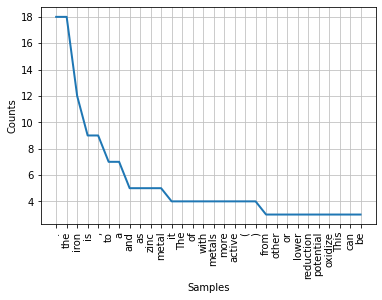

In [ ]:
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [ ]:
def wordContains(fdist,correct):
  a = correct
  num = 0
  correctLen = 1
  for item in fdist.most_common(30):
      if item[0] in a:
        print('Contem: ')
        print(item[0])
        num = num + 1
  print(a)
  print(num)
  if len(correct.split()) != 0:
    correctLen = len(correct.split())
  return num/correctLen

In [ ]:
response = []
for num in range(0,len(train.index)):
  tokenized_word=word_tokenize(train['support'][num])
  fdist = FreqDist(tokenized_word)

  response.append(wordContains(fdist,train['correct_answer'][num]))


Contem: 
or
mesophilic organisms
1
Contem: 
or
coriolis effect
1
Contem: 
the
exothermic
1
Contem: 
decay
Contem: 
alpha
alpha decay
2
Contem: 
and
Contem: 
a
Contem: 
s
Contem: 
an
smoke and ash
4
meteorite
0
Contem: 
reaction
Contem: 
combustion
Contem: 
a
combustion reaction
3
Contem: 
species
Contem: 
in
ring species
2
Contem: 
radioactivity
Contem: 
it
radioactivity
2
Contem: 
endosperm
endosperm
1
Contem: 
a
Contem: 
metal
Contem: 
active
active metal
3
Contem: 
animal
Contem: 
behaviors
Contem: 
a
animal behaviors
3
Contem: 
serving
Contem: 
size
serving size
2
Contem: 
symbols
Contem: 
nuclear
Contem: 
s
nuclear symbols
3
Contem: 
transcription
Contem: 
on
gene transcription
2
Contem: 
oxygen
oxygen
1
circulatory
0
Contem: 
allergy
Contem: 
a
allergy
2
Contem: 
a
Contem: 
zygote
a zygote
2
Contem: 
and
Contem: 
a
Contem: 
asexual
Contem: 
sexual
reproduce asexually and sexually
4
Contem: 
s
enzymes
1
abortion
0
Contem: 
on
Contem: 
one
Contem: 
dead
Contem: 
zones
dead zones
4


In [ ]:
response

[0.5,
 0.5,
 1.0,
 1.0,
 1.3333333333333333,
 0.0,
 1.5,
 1.0,
 2.0,
 1.0,
 1.5,
 1.5,
 1.0,
 1.5,
 1.0,
 1.0,
 0.0,
 2.0,
 1.0,
 1.0,
 1.0,
 0.0,
 2.0,
 0.5,
 1.0,
 1.25,
 1.0,
 1.5,
 1.0,
 1.0,
 1.0,
 1.0,
 1.5,
 1.0,
 0.0,
 1.0,
 0.0,
 2.0,
 0.0,
 1.0,
 0.0,
 0.0,
 2.0,
 0.0,
 1.0,
 4.0,
 1.0,
 0.5,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 0.5,
 1.0,
 0.5,
 2.0,
 1.5,
 1.0,
 0.0,
 1.0,
 1.0,
 2.0,
 1.0,
 0.0,
 1.0,
 1.5,
 1.0,
 2.0,
 1.5,
 0.5,
 0.0,
 3.0,
 1.5,
 1.0,
 2.0,
 1.0,
 0.0,
 5.0,
 0.0,
 2.0,
 2.0,
 2.0,
 3.0,
 0.0,
 0.0,
 1.0,
 0.5,
 1.5,
 0.0,
 2.0,
 0.0,
 0.6666666666666666,
 1.0,
 1.0,
 1.0,
 1.0,
 1.5,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 0.0,
 0.0,
 0.0,
 2.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.5,
 1.0,
 2.0,
 1.3333333333333333,
 1.5,
 1.0,
 2.0,
 0.0,
 1.0,
 2.0,
 0.5,
 2.0,
 0.5,
 0.0,
 0.14285714285714285,
 0.0,
 1.0,
 0.0,
 0.0,
 3.0,
 0.0,
 2.0,
 1.5,
 0.0,
 1.6666666666666667,
 0.5,
 2.0,
 2.0,
 0.0,
 0.0,

In [ ]:
sum(response)/len(response)

1.0319642857142857

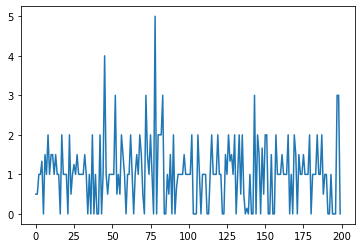

In [ ]:
plt.plot(response)
plt.show()

In [ ]:
train['Support_Most_Frequent_Correct_Answer_'] = response

In [ ]:
train.head()

,question,distractor3,distractor1,distractor2,correct_answer,support,Support_Most_Frequent_Correct_Answer_
0,What type of organism is commonly used in prep...,viruses,protozoa,gymnosperms,mesophilic organisms,"Mesophiles grow best in moderate temperature, ...",0.500000
1,What phenomenon makes global winds blow northe...,tropical effect,muon effect,centrifugal effect,coriolis effect,Without Coriolis Effect the global winds would...,0.500000
2,Changes from a less-ordered state to a more-or...,endothermic,unbalanced,reactive,exothermic,Summary Changes of state are examples of phase...,1.000000
3,What is the least dangerous radioactive decay?,zeta decay,beta decay,gamma decay,alpha decay,All radioactive decay is dangerous to living t...,1.000000
4,Kilauea in hawaii is the world’s most continuo...,magma,greenhouse gases,carbon and smog,smoke and ash,Example 3.5 Calculating Projectile Motion: Hot...,1.333333


### Analisando similaridades

In [ ]:
!pip install spacy
!spacy download en
!spacy download en_core_web_lg
  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-10-05 00:37:24.431854: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 29.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2022-10-05 00:37:32.630574: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 8.9 kB/s 
✔ Download and installation successf

In [ ]:
#Analisando similaridade das perguntas com o texto de apoio e com as respostas
import numpy as np
import spacy
nlp = spacy.load('en_core_web_lg')
a = nlp(train['question'][3])
b = nlp(train['support'][3])
c = nlp(train['correct_answer'][3])
d = nlp(train['distractor1'][3])
e = nlp(train['distractor2'][3])
f = nlp(train['distractor3'][3])

print('Similaridades: ')
print('Pergunta com texto de apoio')
print(a.similarity(b))
print('Pergunta com resposta correta')
print(a.similarity(c))
print('Texto de apoio com resposta correta')
print(b.similarity(c))
print('Texto de apoio com resposta errada')
print(b.similarity(d))
print('Resposta correta com primeira resposta errada')
print(c.similarity(d))
print('Resposta correta com segunda resposta errada')
print(c.similarity(e))
print('Resposta correta com terceira resposta errada')
print(c.similarity(f))
print('Pergunta com resposta errada')
print(a.similarity(d))



Similaridades: 
Pergunta com texto de apoio
0.8848765543090835
Pergunta com resposta correta
0.5744521205437217
Texto de apoio com resposta correta
0.572295285755935
Texto de apoio com resposta errada
0.48907156613194586
Resposta correta com primeira resposta errada
0.8818735015091146
Resposta correta com segunda resposta errada
0.8931770192893865
Resposta correta com terceira resposta errada
0.8414606505515623
Pergunta com resposta errada
0.4810495168576621


In [ ]:
def calc_similarity_mean(index,df):
  ans = nlp(df['correct_answer'][index])
  dis1 = nlp(df['distractor1'][index])
  dis2 = nlp(df['distractor2'][index])
  dis3 = nlp(df['distractor3'][index])

  sim1 = ans.similarity(dis1)
  sim2 = ans.similarity(dis2)
  sim3 = ans.similarity(dis3)

  return np.mean([sim1,sim2,sim3])

In [ ]:
train['average_similarity'] = [calc_similarity_mean(ind,train) for ind in range(0,len(train['support']))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  


In [ ]:
train['average_similarity']

0      0.676375
1      0.910517
2      0.608988
3      0.872170
4      0.576542
         ...   
195    0.593044
196    0.809232
197    0.394204
198    0.546027
199    0.428297
Name: average_similarity, Length: 200, dtype: float64

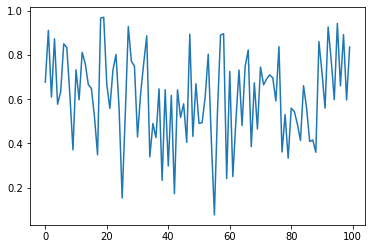

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train['average_similarity'].head(100))
plt.show()

## Processamento do texto

In [ ]:
import nltk
import re
import string
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

stop_words = set(stopwords.words('english'))



vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,2))

def token(text):
  text = text.translate(string.punctuation)
  text = text.lower()
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(text)

  tokens = [word for word in tokens
            if word not in stop_words
                and len(word) > 3          
                and not word[0].isdigit()]

  return ' '.join(tokens)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [ ]:
def preprocess(text):
  return token(text)

#tokens_train = train['question'].apply(preprocess)

#dataquestionstrain  = vectorizer.fit_transform(tokens_train)  

#dataquestionstest = vectorizer.fit_transform(test['question'].apply(preprocess))

#datatest = vectorizer.fit_transform(test['support'].apply(preprocess))

#datatrain = vectorizer.fit_transform(test['support'].apply(preprocess))


### Aplicando preprocessamento

In [ ]:
df = train

In [ ]:
df['support'] = train['support'].apply(preprocess)
df['question'] = train['question'].apply(preprocess)
df['correct_answer'] = train['correct_answer'].apply(preprocess)
df['distractor1'] = train['distractor1'].apply(preprocess)
df['distractor2'] = train['distractor2'].apply(preprocess)
df['distractor3'] = train['distractor3'].apply(preprocess)


df['support_pos'] = [nltk.pos_tag(i.split(),tagset='universal') for i in df['support']]
df['question_pos'] = [nltk.pos_tag(i.split(),tagset='universal') for i in df['question']]
df['correct_answer_pos'] = [nltk.pos_tag(i.split(),tagset='universal') for i in df['correct_answer']]
df['distractor1_pos'] = [nltk.pos_tag(i.split(),tagset='universal') for i in df['distractor1']]
df['distractor2_pos'] = [nltk.pos_tag(i.split(),tagset='universal') for i in df['distractor2']]
df['distractor3_pos'] = [nltk.pos_tag(i.split(),tagset='universal') for i in df['distractor3']]

In [ ]:
train['question'][4]

'kilauea hawaii world continuously active volcano active volcanoes characteristically eject rocks lava rather'

In [ ]:
df['question'][4]

'kilauea hawaii world continuously active volcano active volcanoes characteristically eject rocks lava rather'

In [ ]:
df['question_pos'][4]

[('kilauea', 'NOUN'),
 ('hawaii', 'NOUN'),
 ('world', 'NOUN'),
 ('continuously', 'ADV'),
 ('active', 'ADJ'),
 ('volcano', 'NOUN'),
 ('active', 'ADJ'),
 ('volcanoes', 'NOUN'),
 ('characteristically', 'ADV'),
 ('eject', 'VERB'),
 ('rocks', 'NOUN'),
 ('lava', 'VERB'),
 ('rather', 'ADV')]

### Testando similaridade depois do preprocessamento

In [ ]:
df['average_similarity'] = [calc_similarity_mean(ind,df) for ind in range(0,len(df['support']))]

NameError: ignored

In [ ]:
plt.plot(df['average_similarity'].head(200))
plt.show()

## Geração de perguntas

**Baseado na implementação de:**

Author: **Ramsri Goutham Golla**  [Linkedin](https://www.linkedin.com/in/ramsrig/)   [Twitter](https://twitter.com/ramsri_goutham/)





BERT Word Sense Disambiguation is adapted from the awesome repo here. [BERT WSD](https://github.com/BPYap/BERT-WSD) 

In [ ]:
!pip install --quiet transformers==2.9.0
!pip install --quiet nltk==3.4.5

     |████████████████████████████████| 635 kB 14.4 MB/s 
     |████████████████████████████████| 880 kB 70.9 MB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 5.6 MB 51.8 MB/s 
     |████████████████████████████████| 1.5 MB 16.6 MB/s 


### Gerando os distractors (respostas erradas) 

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

sentence1 = "Joana loves to watch cricket during his free time"
sentence2 = "Joana is annoyed by a cricket in his room"

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# An example of a word with two different senses
original_word = "cricket"

syns = wn.synsets(original_word,'n')

for syn in syns:
  print (syn, ": ",syn.definition(),"\n" )

Synset('cricket.n.01') :  leaping insect; male makes chirping noises by rubbing the forewings together 

Synset('cricket.n.02') :  a game played with a ball and bat by two teams of 11 players; teams take turns trying to score runs 



In [ ]:
# Distractors from Wordnet
def get_distractors_wordnet(syn,word):
    distractors=[]
    word= word.lower()
    orig_word = word
    if len(word.split())>0:
        word = word.replace(" ","_")
    hypernym = syn.hypernyms()
    if len(hypernym) == 0: 
        return distractors
    for item in hypernym[0].hyponyms():
        name = item.lemmas()[0].name()
        #print ("name ",name, " word",orig_word)
        if name == orig_word:
            continue
        name = name.replace("_"," ")
        name = " ".join(w.capitalize() for w in name.split())
        if name is not None and name not in distractors:
            distractors.append(name)
    return distractors


synset_to_use = wn.synsets(original_word,'n')[0]
distractors_calculated = get_distractors_wordnet(synset_to_use,original_word)

print ("\noriginal word: ",original_word.capitalize())
print (distractors_calculated)


original_word = "cricket"
synset_to_use = wn.synsets(original_word,'n')[1]
distractors_calculated = get_distractors_wordnet(synset_to_use,original_word)

print ("\noriginal word: ",original_word.capitalize())
print (distractors_calculated)


original word:  Cricket
['Grasshopper']

original word:  Cricket
['Ball Game', 'Field Hockey', 'Football', 'Hurling', 'Lacrosse', 'Polo', 'Pushball', 'Ultimate Frisbee']


### Download pretrained BERT WSD Model and extract

Download pre-trained BERT WSD from [here](https://entuedu-my.sharepoint.com/:f:/g/personal/boonpeng001_e_ntu_edu_sg/EiWzblOyyOBDtuO3klUbXoAB3THFzke-2MLWguIXrDopWg?e=08umXD)

Click the download button at the top left of the link to download a file named "bert_base-augmented-batch_size=128-lr=2e-5-max_gloss=6.zip"

Place the zip file in your Google drive home folder

In [ ]:
import os
import zipfile

bert_wsd_pytorch = "/content/drive/MyDrive/DatasetPerguntas/bert_base-augmented-batch_size=128-lr=2e-5-max_gloss=6.zip"
extract_directory = "/content/drive/MyDrive/DatasetPerguntas"

extracted_folder = bert_wsd_pytorch.replace(".zip","")

#  If unzipped folder exists don't unzip again.
if not os.path.isdir(extracted_folder):
  with zipfile.ZipFile(bert_wsd_pytorch, 'r') as zip_ref:
      zip_ref.extractall(extract_directory)
else:
  print (extracted_folder," is extracted already")

/content/drive/MyDrive/DatasetPerguntas/bert_base-augmented-batch_size=128-lr=2e-5-max_gloss=6  is extracted already


### Find the correct sense (contextual meaning) of a given word in a sentence

In [ ]:
import torch
import math
from transformers import BertModel, BertConfig, BertPreTrainedModel, BertTokenizer

class BertWSD(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

        self.ranking_linear = torch.nn.Linear(config.hidden_size, 1)

        self.init_weights()


# def _forward(args, model, batch):
#     batch = tuple(t.to(args.device) for t in batch)
#     outputs = model.bert(input_ids=batch[0], attention_mask=batch[1], token_type_ids=batch[2])

#     return model.dropout(outputs[1])
    

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir = "/content/drive/MyDrive/DatasetPerguntas/bert_base-augmented-batch_size=128-lr=2e-5-max_gloss=6"


model = BertWSD.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)
# add new special token
if '[TGT]' not in tokenizer.additional_special_tokens:
    tokenizer.add_special_tokens({'additional_special_tokens': ['[TGT]']})
    assert '[TGT]' in tokenizer.additional_special_tokens
    model.resize_token_embeddings(len(tokenizer))
    
model.to(DEVICE)
model.eval()

BertWSD(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30523, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
import csv
import os
from collections import namedtuple

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

import torch
from tqdm import tqdm

GlossSelectionRecord = namedtuple("GlossSelectionRecord", ["guid", "sentence", "sense_keys", "glosses", "targets"])
BertInput = namedtuple("BertInput", ["input_ids", "input_mask", "segment_ids", "label_id"])



def _create_features_from_records(records, max_seq_length, tokenizer, cls_token_at_end=False, pad_on_left=False,
                                  cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                  sequence_a_segment_id=0, sequence_b_segment_id=1,
                                  cls_token_segment_id=1, pad_token_segment_id=0,
                                  mask_padding_with_zero=True, disable_progress_bar=False):
    """ Convert records to list of features. Each feature is a list of sub-features where the first element is
        always the feature created from context-gloss pair while the rest of the elements are features created from
        context-example pairs (if available)
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """
    features = []
    for record in tqdm(records, disable=disable_progress_bar):
        tokens_a = tokenizer.tokenize(record.sentence)

        sequences = [(gloss, 1 if i in record.targets else 0) for i, gloss in enumerate(record.glosses)]

        pairs = []
        for seq, label in sequences:
            tokens_b = tokenizer.tokenize(seq)

            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

            # The convention in BERT is:
            # (a) For sequence pairs:
            #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
            #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
            #
            # Where "type_ids" are used to indicate whether this is the first
            # sequence or the second sequence. The embedding vectors for `type=0` and
            # `type=1` were learned during pre-training and are added to the wordpiece
            # embedding vector (and position vector). This is not *strictly* necessary
            # since the [SEP] token unambiguously separates the sequences, but it makes
            # it easier for the model to learn the concept of sequences.
            #
            # For classification tasks, the first vector (corresponding to [CLS]) is
            # used as as the "sentence vector". Note that this only makes sense because
            # the entire model is fine-tuned.
            tokens = tokens_a + [sep_token]
            segment_ids = [sequence_a_segment_id] * len(tokens)

            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

            if cls_token_at_end:
                tokens = tokens + [cls_token]
                segment_ids = segment_ids + [cls_token_segment_id]
            else:
                tokens = [cls_token] + tokens
                segment_ids = [cls_token_segment_id] + segment_ids

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

            # Zero-pad up to the sequence length.
            padding_length = max_seq_length - len(input_ids)
            if pad_on_left:
                input_ids = ([pad_token] * padding_length) + input_ids
                input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
                segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            else:
                input_ids = input_ids + ([pad_token] * padding_length)
                input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
                segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            pairs.append(
                BertInput(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids, label_id=label)
            )

        features.append(pairs)

    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import re
import torch
from tabulate import tabulate
from torch.nn.functional import softmax
from tqdm import tqdm
from transformers import BertTokenizer
import time


MAX_SEQ_LENGTH = 128

def get_sense(sent):
  re_result = re.search(r"\[TGT\](.*)\[TGT\]", sent)
  if re_result is None:
      print("\nIncorrect input format. Please try again.")

  ambiguous_word = re_result.group(1).strip()

  results = dict()

  wn_pos = wn.NOUN
  print('aqui 1')
  
  try: 
    for i, synset in enumerate(set(wn.synsets(ambiguous_word, pos=wn_pos))):
        print("/n")
        print("definição")
        print(synset.definition())
        results[synset] =  synset.definition()
  except:
    print('problema no enum')

  if len(results) ==0:
    return (None,None,ambiguous_word)

  print('aqui 2')
  sense_keys=[]
  definitions=[]
  for sense_key, definition in results.items():
      sense_keys.append(sense_key)
      definitions.append(definition)


  record = GlossSelectionRecord("test", sent, sense_keys, definitions, [-1])

  features = _create_features_from_records([record], MAX_SEQ_LENGTH, tokenizer,
                                            cls_token=tokenizer.cls_token,
                                            sep_token=tokenizer.sep_token,
                                            cls_token_segment_id=1,
                                            pad_token_segment_id=0,
                                            disable_progress_bar=True)[0]

  with torch.no_grad():
      logits = torch.zeros(len(definitions), dtype=torch.double).to(DEVICE)
      # for i, bert_input in tqdm(list(enumerate(features)), desc="Progress"):
      for i, bert_input in list(enumerate(features)):
          logits[i] = model.ranking_linear(
              model.bert(
                  input_ids=torch.tensor(bert_input.input_ids, dtype=torch.long).unsqueeze(0).to(DEVICE),
                  attention_mask=torch.tensor(bert_input.input_mask, dtype=torch.long).unsqueeze(0).to(DEVICE),
                  token_type_ids=torch.tensor(bert_input.segment_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
              )[1]
          )
      scores = softmax(logits, dim=0)

      preds = (sorted(zip(sense_keys, definitions, scores), key=lambda x: x[-1], reverse=True))


 
  sense = preds[0][0]
  meaning = preds[0][1]
  return (sense,meaning,ambiguous_word)


sentence1 = "Srivatsan loves to watch cricket during his free **time**"


sentence_for_bert = sentence1.replace("**"," [TGT] ")
sentence_for_bert = " ".join(sentence_for_bert.split())
sense,meaning,answer = get_sense(sentence_for_bert)

print (sentence1)
print (sense)
print (meaning)

sentence2 = "Srivatsan is annoyed by a **cricket** in his room"
sentence_for_bert = sentence2.replace("**"," [TGT] ")
sentence_for_bert = " ".join(sentence_for_bert.split())
sense,meaning,answer = get_sense(sentence_for_bert)

print ("\n-------------------------------")
print (sentence2)
print (sense)
print (meaning)



aqui 1
/n
definição
the period of time a prisoner is imprisoned
/n
definição
rhythm as given by division into parts of equal duration
/n
definição
an indefinite period (usually marked by specific attributes or activities)
/n
definição
a person's experience on a particular occasion
/n
definição
a period of time considered as a resource under your control and sufficient to accomplish something
/n
definição
an instance or single occasion for some event
/n
definição
a suitable moment
/n
definição
the continuum of experience in which events pass from the future through the present to the past
/n
definição
a reading of a point in time as given by a clock
/n
definição
the fourth coordinate that is required (along with three spatial dimensions) to specify a physical event
aqui 2
Srivatsan loves to watch cricket during his free **time**
Synset('time.n.02')
a period of time considered as a resource under your control and sufficient to accomplish something
aqui 1
/n
definição
a game played with a

### Generate a question using context and answer with T5

In [ ]:
from transformers import T5ForConditionalGeneration,T5Tokenizer

question_model = T5ForConditionalGeneration.from_pretrained('ramsrigouthamg/t5_squad_v1')
question_tokenizer = T5Tokenizer.from_pretrained('t5-base')

def get_question(sentence,answer):
  text = "context: {} answer: {} </s>".format(sentence,answer)
  print (text)
  max_len = 256
  encoding = question_tokenizer.encode_plus(text,max_length=max_len, pad_to_max_length=True, return_tensors="pt")

  input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]

  outs = question_model.generate(input_ids=input_ids,
                                  attention_mask=attention_mask,
                                  early_stopping=True,
                                  num_beams=5,
                                  num_return_sequences=1,
                                  no_repeat_ngram_size=2,
                                  max_length=200)


  dec = [question_tokenizer.decode(ids) for ids in outs]


  Question = dec[0].replace("question:","")
  Question= Question.strip()
  return Question


sentence1 = "Srivatsan loves to watch cricket during his free **time**"
sentence2 = "Srivatsan is annoyed by a **cricket** in his room"


answer = "cricket"

sentence_for_T5 = sentence1.replace("**"," ")
sentence_for_T5 = " ".join(sentence_for_T5.split()) 
ques = get_question(sentence_for_T5,answer)
print (ques)


print ("\n**************************************\n")
sentence_for_T5 = sentence2.replace("**"," ")
sentence_for_T5 = " ".join(sentence_for_T5.split()) 
ques = get_question(sentence_for_T5,answer)
print (ques)


context: Srivatsan loves to watch cricket during his free time answer: cricket </s>
What sport does Srivatsan enjoy watching?

**************************************

context: Srivatsan is annoyed by a cricket in his room answer: cricket </s>
What insect is in Srivatsan's room?


### Putting it all together

In [ ]:
def getMCQs(sent):
  if sent == '':
    return ''
  sentence_for_bert = sent.replace("**"," [TGT] ")
  sentence_for_bert = " ".join(sentence_for_bert.split())
 
  try:
    sense,meaning,answer = get_sense(sentence_for_bert)
  except:
    
    sense,meaning,answer = 'none'

  if sense is not None:
    distractors = get_distractors_wordnet(sense,answer)
  else: 
    distractors = ["Word not found in Wordnet. So unable to extract distractors."]
  sentence_for_T5 = sent.replace("**"," ")
  sentence_for_T5 = " ".join(sentence_for_T5.split()) 
  ques = get_question(sentence_for_T5,answer)
  return ques,answer,distractors,meaning



print ("\n")
question,answer,distractors,meaning = getMCQs(sentence1)
print (question)
print (answer)
print (distractors)
print (meaning)

print ("\n")
question,answer,distractors,meaning = getMCQs(sentence2)
print (question)
print (answer)
print (distractors)
print (meaning)



context: Srivatsan loves to watch cricket during his free time answer: cricket </s>


/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:1432: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beam_id = beam_token_id // vocab_size


What sport does Srivatsan enjoy watching?
cricket
['Ball Game', 'Field Hockey', 'Football', 'Hurling', 'Lacrosse', 'Polo', 'Pushball', 'Ultimate Frisbee']
a game played with a ball and bat by two teams of 11 players; teams take turns trying to score runs


context: Srivatsan is annoyed by a cricket in his room answer: cricket </s>
What insect is in Srivatsan's room?
cricket
['Grasshopper']
leaping insect; male makes chirping noises by rubbing the forewings together


**Few more examples with disambiguation words (word with contextual meanings)**

In [ ]:
# More examples

sentence = "John went to river **bank** to cry"
# sentence = "John went to deposit money in the **bank**"

# sentence = "John bought a **mouse** for his computer."
# sentence = "John saw a **mouse** under his bed."


print ("\n")
question,answer,distractors,meaning = getMCQs(sentence)
print (question)
print (answer)
print (distractors)
print (meaning)



context: John went to river bank to cry answer: bank </s>
Where did John go to cry?
bank
['Ascent', 'Canyonside', 'Coast', 'Descent', 'Escarpment', 'Hillside', 'Mountainside', 'Piedmont', 'Ski Slope']
sloping land (especially the slope beside a body of water)


### Testando com nosso dataframe

In [ ]:
testeNew = pd.read_csv('/content/drive/MyDrive/DatasetPerguntas/NewDataset/testeNovo.csv')

In [ ]:
sentence3 = testeNew['context'][0]
print(sentence3)

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(testeNew['context'][0])
print(tokenized_word)

['Beyoncé', 'Giselle', 'Knowles-Carter', '(', '/biːˈjɒnseɪ/', 'bee-YON-say', ')', '(', 'born', 'September', '4', ',', '1981', ')', 'is', 'an', 'American', 'singer', ',', 'songwriter', ',', 'record', 'producer', 'and', 'actress', '.', 'Born', 'and', 'raised', 'in', 'Houston', ',', 'Texas', ',', 'she', 'performed', 'in', 'various', 'singing', 'and', 'dancing', 'competitions', 'as', 'a', 'child', ',', 'and', 'rose', 'to', 'fame', 'in', 'the', 'late', '1990s', 'as', 'lead', 'singer', 'of', 'R', '&', 'B', 'girl-group', 'Destiny', "'s", 'Child', '.', 'Managed', 'by', 'her', 'father', ',', 'Mathew', 'Knowles', ',', 'the', 'group', 'became', 'one', 'of', 'the', 'world', "'s", 'best-selling', 'girl', 'groups', 'of', 'all', 'time', '.', 'Their', 'hiatus', 'saw', 'the', 'release', 'of', 'Beyoncé', "'s", 'debut', 'album', ',', 'Dangerously', 'in', 'Love', '(', '2003', ')', ',', 'which', 'established', 'her', 'as', 'a', 'solo', 'artist', 'worldwide', ',', 'earned', 'five', 'Grammy', 'Awards', 'and'

In [ ]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 95 samples and 139 outcomes>


In [ ]:
listCommun = fdist.most_common(10)

In [ ]:
listCommun

[(',', 11),
 ('and', 6),
 ('in', 5),
 ('the', 5),
 ('.', 4),
 ('of', 4),
 ('(', 3),
 (')', 3),
 ('as', 3),
 ("'s", 3)]

In [ ]:
sentence3 = sentence3.replace('Beyoncé','**Beyoncé**')

In [ ]:
sentence3

'**Beyoncé** Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of **Beyoncé**\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [ ]:
question,answer,distractors,meaning = getMCQs(sentence3)

context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé 's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy". answer: Beyoncé [TGT] Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 

In [ ]:
question

"What is Beyoncé's full name?"

In [ ]:
answer

"Beyoncé [TGT] Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of [TGT] Beyoncé"

In [ ]:
distractors

['Word not found in Wordnet. So unable to extract distractors.']

In [ ]:
meaning

In [ ]:
testeNewPro = testeNew
testeNewPro['context'] = testeNewPro['context'].apply(preprocess)

def mostUse(text):
  if text == '':
    return 'none'
  new = text
  tokenized_word=word_tokenize(new)
  fdist = FreqDist(tokenized_word)
  listCommun = fdist.most_common(10)
  if listCommun[0] == 'n':
    print(listCommun[0])
  return listCommun[0]

testeNewPro['mostUse'] = testeNewPro['context'].apply(mostUse)

In [ ]:
testeNewPro.tail()

,Unnamed: 0,question,answer,context,mostUse
748,748,What crowdfunding platform was used in the con...,Catapult,december beyoncé along variety celebrities tea...,"(campaign, 7)"
749,749,What is the name of the campaign that Beyoncé ...,Demand A Plan,december beyoncé along variety celebrities tea...,"(campaign, 7)"
750,750,What school shooting prompted the creation of ...,Sandy Hook Elementary School,december beyoncé along variety celebrities tea...,"(campaign, 7)"
751,751,What song did Beyoncé donate to the 2012 World...,I Was Here,december beyoncé along variety celebrities tea...,"(campaign, 7)"
752,752,Who did Beyoncé work with in 2013 on the Chime...,Salma Hayek and Frida Giannini,december beyoncé along variety celebrities tea...,"(campaign, 7)"


In [ ]:
testeNewPro['mostUse'][0]

('beyoncé', 2)

In [ ]:
def replaceWords(text,support):
  text = text.replace("'","")
  if text == 'n':
    return support.replace(text,(f"**none**"))
  return support.replace(text,(f"**{text}**"))

In [ ]:
#Ta surgindo um n nos most use, tentei tirar mas n ta indo vou fazer manual msm por enquanto
for item in range (0,752):
  testeNewPro['context'][item] = replaceWords(testeNewPro['mostUse'][item][0],testeNewPro['context'][item])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
testeNewPro['mostUse'][10]

('beyoncé', 2)

In [ ]:
testeNewPro['mostUse'][10][0]

'beyoncé'

In [ ]:
testeNewPro['mostUse'].unique()

array([('beyoncé', 2), ('album', 4), ('artist', 5), ('beyoncé', 4),
       ('school', 7), ('group', 7), ('group', 8), ('album', 5),
       ('beyoncé', 5), ('destiny', 6), ('second', 3), ('film', 4),
       ('video', 9), ('year', 4), ('birth', 2), ('beyoncé', 3),
       ('beyoncé', 6), ('february', 1), ('august', 2), ('blue', 3),
       ('april', 2), ('letter', 2), ('death', 2), ('million', 9),
       ('vocal', 5), ('received', 2), ('number', 4), ('jackson', 4),
       ('tour', 4), ('sasha', 5), ('fashion', 4), ('name', 3),
       ('beyoncé', 7), ('single', 4), ('artist', 7), ('awards', 7),
       ('topshop', 3), ('music', 5), ('deréon', 5), ('launch', 3),
       ('hurricane', 2), ('campaign', 7)], dtype=object)

In [ ]:
testeNewPro['context'][10]

'**beyoncé** giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release **beyoncé** debut album dangerously love established solo artist worldwide earned five grammy awards featured billboard number singles crazy love baby'

In [ ]:
question,answer, distractors,meaning = getMCQs(testeNewPro['context'][4])

context: beyoncé giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release beyoncé debut album dangerously love established solo artist worldwide earned five grammy awards featured billboard number singles crazy love baby answer: beyoncé [TGT] giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release [TGT] beyoncé </s>


/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:1432: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beam_id = beam_token_id // vocab_size


In [ ]:
question

"What is the name of Beyonce's debut album dangerously love?"

In [ ]:
answer

'beyoncé [TGT] giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release [TGT] beyoncé'

In [ ]:
testeNew['question'][4]

'In which decade did Beyonce become famous?'

In [ ]:
testeNew['answer'][4]

'late 1990s'

In [ ]:
distractors

['Word not found in Wordnet. So unable to extract distractors.']

In [ ]:
len(testeNewPro['context'])

753

In [ ]:
testeNewPro['mostUse'][703]

('beyoncé', 5)

### teste

In [ ]:
teste_Train = testeNewPro.iloc[:10,:]

In [ ]:
teste_Train['Newquestion'] = teste_Train['context'].apply(getMCQs)

aqui 1
context: beyoncé giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release beyoncé debut album dangerously love established solo artist worldwide earned five grammy awards featured billboard number singles crazy love baby answer: beyoncé [TGT] giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release [TGT] beyoncé </s>
aqui 1
context: beyoncé giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised ho

KeyboardInterrupt: ignored

In [ ]:
teste_Train['Newquestion'][0]

("What is the name of Beyonce's debut album dangerously love?",
 'beyoncé [TGT] giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release [TGT] beyoncé',
 ['Word not found in Wordnet. So unable to extract distractors.'],
 None)

In [ ]:
for i in teste_Train['Newquestion']:
  if "Word not found in Wordnet" not in i[2][0]:
    print(i)

In [ ]:
testeNewPro['Newquestion'] = testeNewPro['context'].apply(getMCQs)


context: beyoncé giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release beyoncé debut album dangerously love established solo artist worldwide earned five grammy awards featured billboard number singles crazy love baby answer: beyoncé [TGT] giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas performed various singing dancing competitions child rose fame late lead singer girl group destiny child managed father mathew knowles group became world best selling girl groups time hiatus release [TGT] beyoncé </s>
context: beyoncé giselle knowles carter biːˈjɒnseɪ born september american singer songwriter record producer actress born raised houston texas pe

UnboundLocalError: ignored

In [ ]:
testeNewPro.head()

## Visualização inicial

In [ ]:
!pip install pyLDAvis

import pyLDAvis.sklearn
import pyLDAvis
import matplotlib.pyplot as plt
#%matplotlib inline

pyLDAvis.enable_notebook()
# panel = pyLDAvis.sklearn.prepare(lda_model, 
#                                  tokens_nltk, 
#                                  vectorizer, 
#                                  mds='tsne', 
#                                 sort_topics=False )
# panel
